# Milestone 2

---

Milestones ini dibuat guna mengevaluasi pembelajaran pada Hacktiv8 Data Science Full Time Program Phase 2 khususnya pada Deep Learning.

## Introduction

By [Rifky Aliffa](https://github.com/Penzragon)

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg/1200px-The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg)

### Dataset

Pada project ini dataset yang digunakan adalah berbagai macam gambar kebakaran dan api. Dataset dapat dilihat di [Kaggle](https://www.kaggle.com/datasets/phylake1337/fire-dataset).

### Objectives

**Milestones 2** ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.

Dan tujuan utama dari project ini adalah untuk membuat model CNN yang mampu mendeteksi apakah terjadi kebakaran atau tidak.

## Import Libraries

Pada project ini library yang akan digunakan adalah **Pandas**, **Numpy**, **Matplotlib**, **Seaborn**, **Tensorflow**, **Keras**, dan **Scikit-Learn**.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

Membuat dataframe yang berisi path dari gambar berikut labelnya.

In [3]:
# Create an empty dataframe
fire = pd.DataFrame(columns=['image', 'label'])

# Loop through fire_images directory and add each image and label to the dataframe
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/fire_images'):
    for filename in filenames:
        fire = fire.append({'image': os.path.join(dirpath, filename), 'label': 'fire'}, ignore_index=True)

# Loop through non_fire_images directory and add each image and label to the dataframe
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/non_fire_images'):
    for filename in filenames:
        fire = fire.append({'image': os.path.join(dirpath, filename), 'label': 'non_fire'}, ignore_index=True)
        
# Shuffle the dataframe
fire = fire.sample(frac=1).reset_index(drop=True)

In [4]:
fire.head(20)

,image,label
0,dataset/fire_dataset/non_fire_images\non_fire....,non_fire
1,dataset/fire_dataset/fire_images\fire.213.png,fire
2,dataset/fire_dataset/non_fire_images\non_fire....,non_fire
3,dataset/fire_dataset/fire_images\fire.164.png,fire
4,dataset/fire_dataset/fire_images\fire.247.png,fire
5,dataset/fire_dataset/fire_images\fire.722.png,fire
6,dataset/fire_dataset/fire_images\fire.105.png,fire
7,dataset/fire_dataset/fire_images\fire.153.png,fire
8,dataset/fire_dataset/fire_images\fire.380.png,fire
9,dataset/fire_dataset/fire_images\fire.165.png,fire


In [5]:
fire.shape

(999, 2)

Data ini berisi **999 gambar** dengan 2 label yaitu **fire** dan **non_fire**.

## Exploratory Data Analysis (EDA)

### Label

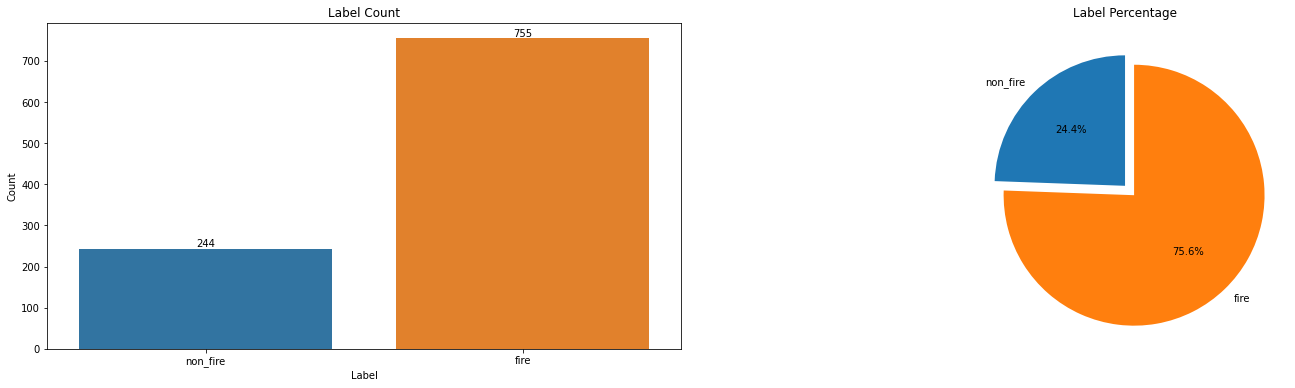

In [6]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x='label', data=fire)
for p in fig.patches:
    height = p.get_height()
    fig.text(p.get_x() + p.get_width()/2., height + 0.5, height, ha='center', va='bottom')
plt.title('Label Count')
plt.xlabel('Label')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.pie(fire['label'].value_counts().reindex(['non_fire', 'fire']), labels=fire.label.value_counts().reindex(['non_fire', 'fire']).index, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
plt.title('Label Percentage')
plt.show()

Pada dataset terdapat **label imbalanced** dimana jumlah gambar berlabel non_fire lebih sedikit dibandingkan gambar berlabel fire yaitu hanya **244 gambar** atau sekitar **24%** gambar saja yang memiliki label non_fire.

### Fire Image Samples

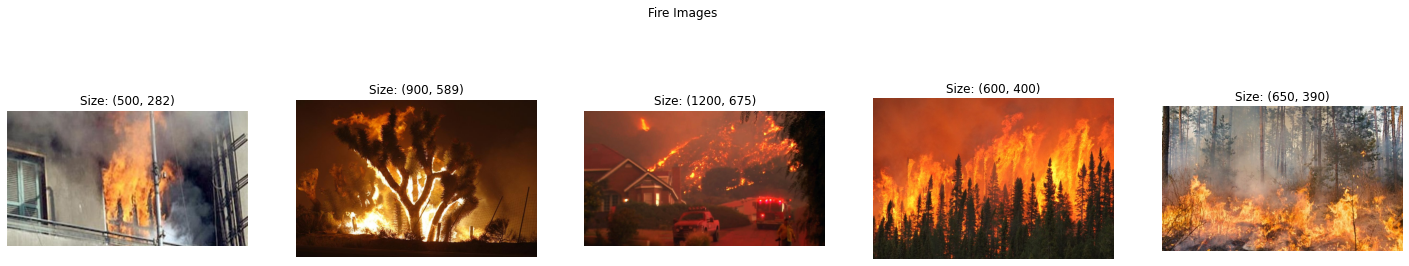

In [7]:
plt.figure(figsize=(25, 5))
plt.suptitle('Fire Images')
for i in range(5):
    img = image.load_img(fire[fire.label == 'fire'].sample(1).image.values[0])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

Plot diatas merupakan 5 sample dari gambar dengan yang berlabel **fire**, jika dilihat setiap gambar memiliki ukuran yang berbeda-beda.

### Non Fire Image Samples

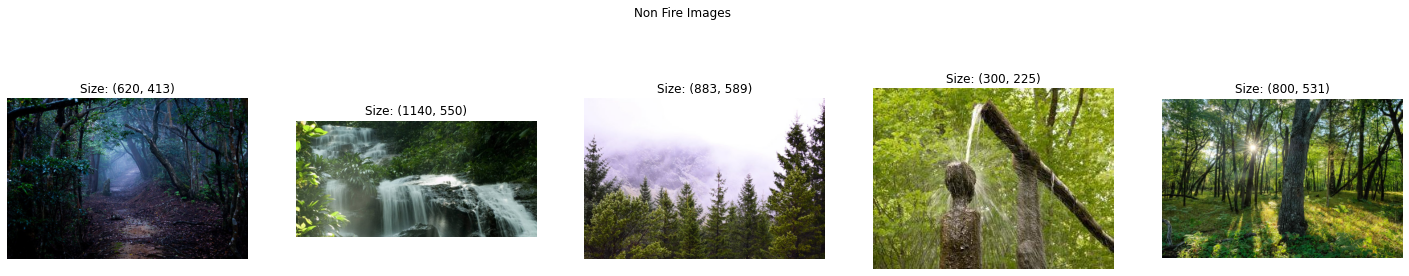

In [8]:
plt.figure(figsize=(25, 5))
plt.suptitle('Non Fire Images')
for i in range(5):
    img = image.load_img(fire[fire.label == 'non_fire'].sample(1).image.values[0])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

Gambar diatas merupakah sample dari gambar yang berlabel **non_fire**. Sama seperti gambar dengan label fire, gambar-gambar diatas juga memiliki ukuran yang berbeda untuk setiap gambarnya.

## Data Preprocessing

In [20]:
generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [21]:
train_generator = generator.flow_from_dataframe(dataframe=fire, x_col='image', y_col='label', subset='training', batch_size=32, class_mode='binary', shuffle=True, seed=23, target_size=(224, 224))
validation_generator = generator.flow_from_dataframe(dataframe=fire, x_col='image', y_col='label', subset='validation', batch_size=32, class_mode='binary', shuffle=True, seed=23, target_size=(224, 224))

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


## Model Definition

In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 93312)             0         
                                                                 
 dense_5 (Dense)             (None, 64)               

## Model Training

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
25/25 [==============================] - 17s 689ms/step - loss: 0.3308 - accuracy: 0.8913 - val_loss: 0.1450 - val_accuracy: 0.9447
Epoch 2/30
25/25 [==============================] - 17s 674ms/step - loss: 0.1401 - accuracy: 0.9400 - val_loss: 0.1190 - val_accuracy: 0.9548
Epoch 3/30
25/25 [==============================] - 17s 658ms/step - loss: 0.0735 - accuracy: 0.9675 - val_loss: 0.2007 - val_accuracy: 0.9447
Epoch 4/30
25/25 [==============================] - 16s 666ms/step - loss: 0.0728 - accuracy: 0.9688 - val_loss: 0.1581 - val_accuracy: 0.9497
Epoch 5/30
25/25 [==============================] - 16s 652ms/step - loss: 0.0686 - accuracy: 0.9787 - val_loss: 0.1655 - val_accuracy: 0.9447
Epoch 6/30
25/25 [==============================] - 16s 644ms/step - loss: 0.0402 - accuracy: 0.9875 - val_loss: 0.1988 - val_accuracy: 0.9648
Epoch 7/30
25/25 [==============================] - 16s 649ms/step - loss: 0.0266 - accuracy: 0.9887 - val_loss: 0.1254 - val_accuracy: 0.9548

## Model Evaluation

In [26]:
metrics = pd.DataFrame(history.history)

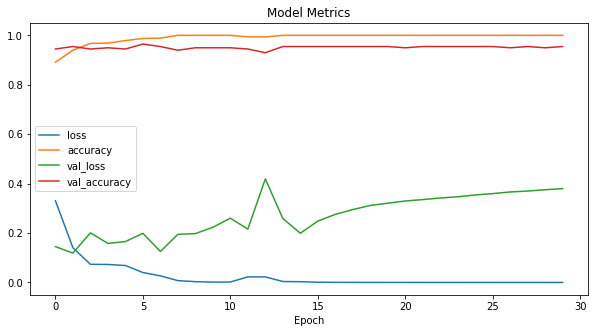

In [27]:
metrics.plot(figsize=(10, 5))
plt.title('Model Metrics')
plt.xlabel('Epoch')
plt.show()

In [30]:
print('-------------Training Set----------------')
print(classification_report(train_generator.classes, model.predict(train_generator).round()))
print('-------------Validation Set----------------')
print(classification_report(validation_generator.classes, model.predict(validation_generator).round()))

-------------Training Set----------------
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       607
           1       0.19      0.19      0.19       193

    accuracy                           0.61       800
   macro avg       0.47      0.47      0.47       800
weighted avg       0.61      0.61      0.61       800

-------------Validation Set----------------
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       148
           1       0.28      0.27      0.28        51

    accuracy                           0.63       199
   macro avg       0.52      0.52      0.52       199
weighted avg       0.63      0.63      0.63       199



In [31]:
print(train_generator.class_indices)

{'fire': 0, 'non_fire': 1}


## Inference

In [44]:
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize

def load_and_preprocess(filename, img_shape=224):
  img = read_file(filename)
  img = decode_image(img, channels=3)
  img = resize(img, size=[img_shape, img_shape])
  img = img/255.
  return img

In [46]:
new_img1 = load_and_preprocess('fire.jpeg')
new_img2 = load_and_preprocess('nonfire.jpeg')

In [48]:
new_img1.shape

TensorShape([224, 224, 3])

In [49]:
new_img2.shape

TensorShape([224, 224, 3])

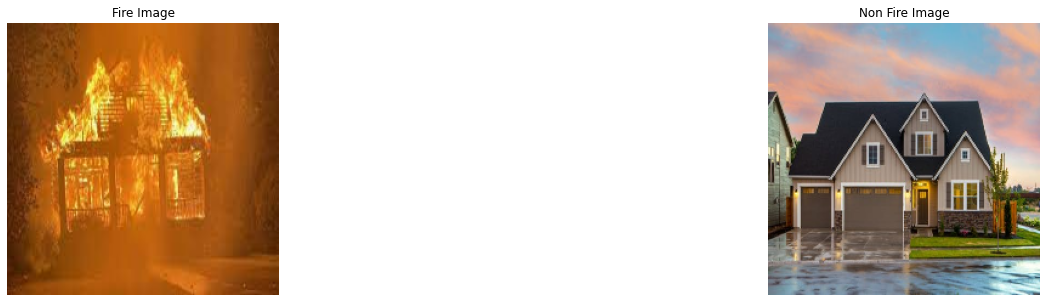

In [47]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.imshow(new_img1)
plt.title('Fire Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(new_img2)
plt.title('Non Fire Image')
plt.axis('off')
plt.show()

In [50]:
from tensorflow import expand_dims
# benerin dimensi
new_img1 = expand_dims(new_img1, axis=0)
new_img2 = expand_dims(new_img2, axis=0)

In [52]:
res = model.predict(new_img1)
res.argmax()

0

In [53]:
res = model.predict(new_img2)
res.argmax()

0